In [1]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/lantian773030/pokemonclassification")

Skipping, found downloaded files in ".\pokemonclassification" (use force=True to force download)


In [16]:
!pip install opendatasets

You should consider upgrading via the 'C:\Users\Stepan\deep_learning\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Напишем свой класс dataseta

In [4]:
#GPU занимается обучением
#CPU готовит батчи ( аугментации применяет и все такое)
#Подгрузка с диска ест много времени, попытамся ускорить, но тут это ваще не особо сработало
#Предлагается подгрузить датасет в оперативную память load_to_ram

In [5]:
import os
import shutil
from PIL import Image #Будет загружать картинки 
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

class PokemonDataset(Dataset):
    #Случайный split и размер testa
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25
    #Нужно поделить картинки так, чтобы сохранялся баланс классов в train и test.
    #Походимся по каждому классу и закидываем 75% в train, 25% в test
    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        
        super().__init__()
        #root - папка PokemonDate
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram #загрузить в оперативную память
        self.transform = transform
        self.all_files = [] #Для сохранения файлов
        self.all_labels = []# Для сохранения меток
        self.images = []
        self.classes = sorted(os.listdir(self.root)) # отсортируем папки
        
        #прописывам total в tqdm так как enumerate - это генератор, а у него не определена длина, поэтому прогресс бар будет плакоть
        for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)): 
            #os.path.join - функция которая умеет склеивать пути
            files = sorted(os.listdir(os.path.join(self.root, class_name)))#отсортируем
            #разобьем данные ( для каждогокласса свой RANDOM_SEED)
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i, 
                                                      test_size=self.TEST_SIZE)
            #Разделение на train и test (так чтобы сохранялся баланс классов)
            if self.train:#Если мы в train передали True
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)
            else:# если test
                self.all_files += test_files
                self.all_labels += [i] * len(test_files)
                if self.load_to_ram:
                    self.images += self._load_images(test_files, i)
    
    
    def _load_images(self, image_files, label):# передаем в нее массив путей для картинок
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]
           
        return images
    
    
    def __len__(self): #чтобы понимать сколько элементов в эпохе, чтобы dataloader понял когда закончить итерироваться
        return len(self.all_files) 
    
    
    #будет возвращать картинку и метку, чтобы мы это в dataloader засунули, чтоб он батчи формировал и радовались жизни
    def __getitem__(self, item):
        filename = self.all_files[item]
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            #Нужно соединить путь исходный, добавить сюда имя класса и добавить имя
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
        #чтобы мы поддерживали аугументацию нада это 
        if self.transform is not None:
            image = self.transform(image) 
        return image, label 
    #Получается в итоге dataloader формирует нам батчи, где первым элементом будет картинка (4-х мерный тензор),
    #и Label (массив из меток)
    
    

In [6]:
import glob 
bad_images = glob.glob('pokemonclassification/PokemonData/*/*.svg')

In [7]:
#эти картинки формата SVG все ломают
for bad_image in bad_images:
    os.remove(bad_image)

In [25]:
#train_dataset = PokemonDataset(root='pokemonclassification/PokemonData', train=True)

In [9]:
image, label = train_dataset[149]

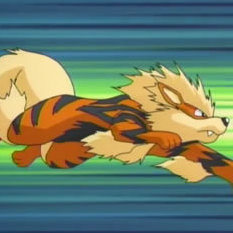

In [10]:
image

In [12]:
train_dataset.classes[label]

'Arcanine'

In [13]:
len(train_dataset)

5063

#### В следующей ячейке описаны обучающие ( с аугментациями) и тестовы трансформмы ( без аугментаций) для картинок ( для ImageNeta)

In [8]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


In [9]:

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [10]:
train_dataset = PokemonDataset(root='pokemonclassification/PokemonData', train=True, load_to_ram=True, transform=test_transform)
test_dataset = PokemonDataset(root='pokemonclassification/PokemonData', train=False, load_to_ram=True, transform=test_transform)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:02<?, ?it/s]

In [11]:
# с pin_memory = True - ускоряет обучение 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(train_losses, test_losses, traon_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')
    axs[0].grid()
    
    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')
    axs[1].grid()
    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()
    plt.show()

In [13]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)# images: batch_size x num_channels x height x width
        labels = labels.to(device)# labels: batch_size
     
        optimizer.zero_grad()
        logits = model(images) # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    
    return train_loss, train_accuracy



@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        
        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        
    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(model, optimizer, 
        criterion, train_loader, tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        
        test_loss, test_accuracy = validation_epoch(model, criterion, test_loader,
        tqdm_desc=f'Validation {epoch}/{num_epochs}')
        
        if scheduler is not None:
            scheduler.step()
        
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        
    return train_losses, test_losses, train_accuracies, test_accuracies

In [14]:
#Используем готовую архитектуру
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
num_epochs = 10  
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs )

In [15]:
#model
#Так считаем число обучаемых параметров в модели
sum(param.numel() for param in model.parameters())

2416022

In [16]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)

Training 1/10:   0%|          | 0/159 [00:00<?, ?it/s]

Validation 1/10:   0%|          | 0/56 [00:03<?, ?it/s]

NameError: name 'criterin' is not defined